# Regressão Linear

In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from sklearn import datasets

SEED=200

plt.ion()

In [2]:
def rescale(df, columns, nmin=0, nmax=1):
    """
    df: dataframe com o dataset
    columns: nomes das colunas que devem ser reescaladas
    retorna o dataset reescalado
    """
    from copy import copy
    rescaledDF = copy(df)
    
    for c in columns:
        minc,maxc = min(df[c]),max(df[c])
        rescaled = (df[c] - minc) * (nmax-nmin) / (maxc - minc) + nmin
        rescaledDF[c] = rescaled
        
    return rescaledDF

def line_equation(theta, x):
    """Equação da reta
    theta (nparray): Numpy array com os coeficientes da equação da reta (e.g. np.array([0.1, 0.3]))
    x (float): Valor float do eixo x
    retorna o valor do eixo y resultante 
    """
    return theta[0] + theta[1]*x

### A equação normal encontra os parâmetros ideais de forma analítica. A equação pode ser encontrada ao setar as derivadas parciais da função de custo para 0.

$$\Theta = (X^tX)^{-1}X^tf(x)$$

Muitas vezes pode não haver inversa. Quando isso acontece pode-se realizar aproximações numéricas.


In [3]:
def normal_equation(df):
    """Equação normal que calcula o resultado final ideal para os pesos
    df (dataframe): Pandas dataframe com os dados
    retorna um numpy array com os valores de theta resultantes da equação. Podem ser Nulos
    """
    X = df.iloc[:,:-1].values
    X = np.asarray(list(map(lambda x : np.asarray([1] + list(x)), X)))
    Xt = X.transpose()
    Y = df.iloc[:,-1].values
    
    from numpy.linalg import inv, pinv
    from numpy import matmul
    
    theta = matmul(Xt,X)
    
    try:
        theta = inv(theta)
    except:
        theta = pinv(theta)
    
    theta = matmul(matmul(theta,Xt),Y)
    
    return theta

### Primeiro passo é abrir os dados.
#### Nesse caso os dados estão em train_reg.csv. Um subset com os 200 primeiros elementos é retirado do csv.

In [4]:
"""Nao alterar"""
df = pd.read_csv('datasets/regression/train_reg.csv')
df = rescale(df, columns=df.columns[:])

# Try the normal equation for the first 200
subset = df.iloc[0:200]
X, Y = subset.iloc[:,0], subset.iloc[:,1]

#### Em seguida deve ser utilizada a equação normal para encontrar os valores ideais de theta

<IPython.core.display.Javascript object>


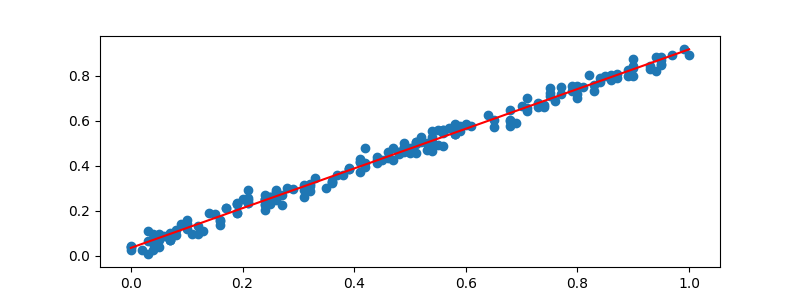

In [5]:
"""Nao alterar"""
theta = normal_equation(subset)

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.scatter(X, Y)

line = [0] * 2
line[0] = line_equation(theta, X.min())
line[1] = line_equation(theta, X.max())

drawn, = ax.plot((X.min(), X.max()), (line[0], line[1]), c='r')
fig.canvas.draw()

### A segunda abordagem é utilizando o Gradiente Descendente

In [6]:
def gradient_descent_step(df, theta, learning_rate=1e-5):
    """Realiza um passo do gradiente descendente
    
    Args:
        df (dataframe): Conjunto de dados (X, Y)
        theta (nparray): Numpy Array com os valores de theta na iteração anterior do treinamento
        learning_rate (float): Taxa de aprendizado alpha
        
    Returns:
        nparray: um conjunto novo de Theta
        float: erro
    
    """
    from numpy import matmul
    
    if type(theta) == list:
        theta = np.asarray(theta)
    
    assert df.shape[1] == len(theta) # the class represents the dummy feature
    
    updated = []
    for j in range(len(theta)): # j in (0 .. m)
        ac = 0
        
        for i in range(df.shape[0]): # i in (0 .. N-1)
            Xi = np.asarray([1] + list(df.iloc[i,:-1].values))
            Yi = df.iloc[i,-1]
            
            tmp = matmul(theta,Xi) - Yi
            ac += tmp * Xi[j]
            
        ac = ac*learning_rate/df.shape[0]
        updated.append(theta[j] - ac)

    mse = 0
    for i in range(df.shape[0]): # i in (0 .. N)
        Xi = list(df.iloc[i,:-1].values)
        Xi = np.asarray([1] + Xi)
        Yi = df.iloc[i,-1]
        
        pred = 0
        for ti, xj in zip(updated,Xi):
            pred += ti*xj
            
        mse = (pred - Yi) ** 2
    mse = mse/(2*df.shape[0])
        
    return np.asarray(updated),mse

<IPython.core.display.Javascript object>


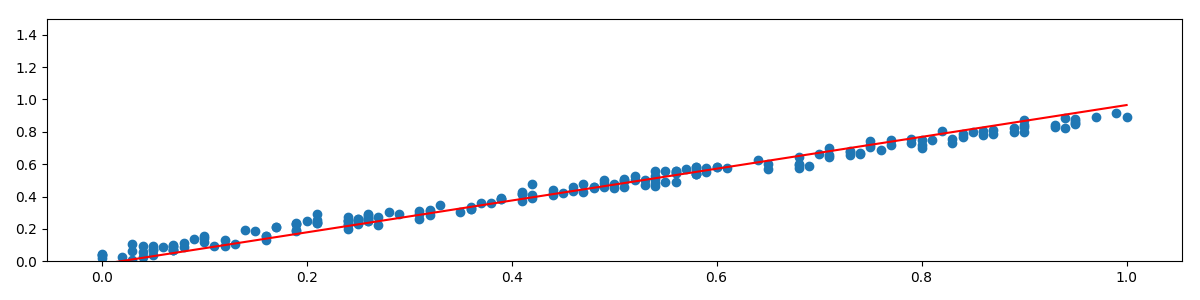

In [7]:
"""Nao alterar"""
# Cria o grafico e atualiza os pesos
fig = plt.figure(tight_layout=True, figsize=(12,3))
ax = fig.add_subplot(111)
ax.scatter(X, Y)

# Inicializa os pesos (theta) e plota a primeira reta do grafico
theta = [3, 4]
line = [0] * 2
line[0] = line_equation(theta, X.min())
line[1] = line_equation(theta, X.max())
drawn, = ax.plot((X.min(), X.max()), (line[0], line[1]), c='r')
ax.set_ylim((0, 1.5))

GRADIENT_DESCENT_ITERATIONS = 75 # Increased number of iterations
t = tqdm(range(0, GRADIENT_DESCENT_ITERATIONS))
for it in t:
    theta, error = gradient_descent_step(df, theta, learning_rate=0.5)
    t.set_description("Error: %.6s     " % error)
    
    # Atualiza o grafico
    line[0] = line_equation(theta, X.min())
    #print(line[0])
    line[1] = line_equation(theta, X.max())
    drawn.set_xdata((X.min(), X.max()))
    drawn.set_ydata((line[0], line[1]))
    fig.canvas.draw()
    
plt.close()

# Regressão Logística

## Carregar o dataset iris
### Escolher entre implementar rescale ou normalize

In [8]:
"""Rescale and normalize functions: implement the missing functions"""
def rescale(df, columns, maximum=None, minimum=None):
    """
    df: a dataframe with the dataset
    columns: the column names from the dataframe that should be rescaled
    maximum: a dictionary with the maximum value with each key representing a column
    minimum: a dictionary with the minimum value with each key representing a column
    """
    from copy import copy
    rescaledDF = copy(df)
    nmax,nmin = {},{}
    
    for c in columns:
        minc,maxc = min(df[c]),max(df[c])
        
        try:
            nmax[c]=maximum[c]
        except:
            nmax[c]=maxc
            
        try:
            nmin[c]=minimum[c]
        except:
            nmin[c]=minc
        
        rescaled = (df[c] - minc) * (nmax[c]-nmin[c]) / (maxc - minc) + nmin[c]
        rescaledDF[c] = rescaled
        
    return rescaledDF,nmax,nmin

def normalize(df, columns, mean=None, std=None):
    """
    df: a dataframe with the dataset
    columns: the column names from the dataframe that should be normalized
    mean: a dictionary with the mean value with each key representing a column
    std: a dictionary with the standard deviation value with each key representing a column
    """
    raise NotImplementedError("implementar normalize")

In [9]:
"""Carrega o iris e deixa somente os dois primeiros atributos, além do atributo alvo. Nao alterar esta celula"""
iris = datasets.load_iris()

df_full = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                       columns=iris['feature_names'] + ['target'])
df_full = df_full[df_full.target != 2.]
df_full = df_full.loc[:,["sepal length (cm)", "sepal width (cm)", "target"]]

def get_train_test_inds(y, train_proportion=0.7):
    """
    y: coluna do atributo alvo
    retorna os indices de treino e teste estratificados pela classe
    """

    y=np.array(y)
    train_inds = np.zeros(len(y),dtype=bool)
    test_inds = np.zeros(len(y),dtype=bool)
    values = np.unique(y)
    for value in values:
        value_inds = np.nonzero(y==value)[0]
        np.random.shuffle(value_inds)
        n = int(train_proportion*len(value_inds))

        train_inds[value_inds[:n]]=True
        test_inds[value_inds[n:]]=True

    return train_inds,test_inds


train_inds, test_inds = get_train_test_inds(df_full.loc[:, "target"])
df_full[['target']] = df_full[['target']].astype(int)
df = df_full[train_inds]
df_val = df_full[test_inds]

In [10]:
"""Use este trecho no caso de optar por reescalar"""
df, maximum, minimum = rescale(df, df.columns[0:4])
df_val, _, _ = rescale(df_val, df_val.columns[0:4], maximum, minimum)

"""Use este trecho no caso de optar por normalizar"""
# df, mean, std = normalize(df, df.columns[0:2])
# df_val, _, _ = normalize(df_val, df_val.columns[0:2], mean, std)

'Use este trecho no caso de optar por normalizar'

In [11]:
"""Função de Ativação Sigmoidal"""
def sigmoid(x):
    from math import e
    sig = e**(-x)
    return 1/(1+sig)

# Implementação da classe de regressão logística

In [12]:
class LogReg(object):
    def __init__(self, input_size, learning_rate=1e-1, sigma=1, weight_decay=0.01):
        self.weight_decay = weight_decay
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.theta = sigma * np.random.randn(input_size)
        self.bias = np.zeros(1)
        self.grads = {}
    
    def forward(self, x):
        """
        x: entrada da rede neural
        retorna as probabilidades de cada classe (batch_size, numero_de_classes)
        """
        pred = []
        self.grads["preds"] = []
        
        for xj in x:
            xj = np.asarray([1]+list(xj))
            t = np.asarray(list(self.bias)+list(self.theta))
            a = np.matmul(t,xj)
            pred.append(sigmoid(a))
            
            self.grads["preds"].append(np.asarray(list(xj)+[pred[-1]]))
            
        return np.asarray(pred)
        
    def backward(self, y):
        """
        y: indices das classes esperadas (batch_size, 1)
        retorna o loss e o dicionario de gradientes
        """
        from math import log
        def CE(pred,yi):
            if yi:
                return -log(pred + 1e-15) #To avoid an unlikely
            return -log(1-pred + 1e-15) #yet possible log(0)
        
        loss = 0
        y = y.values
        df = np.asarray(self.grads["preds"])
        for i, yi in enumerate(y):
            loss += CE(df[i][-1],yi)
        loss = loss/len(y)
        
        del self.grads["preds"]
        
        updated = []
        for j in range(len(self.theta)+1): # j in (0 .. m)
            ac = np.asarray([
                    (df[i][-1] - y[i]) * df[i][j] for i in range(df.shape[0]) # i in (0 .. N-1)
                ]).mean()
            
            updated.append(ac)
        
        self.grads["b"] = np.asarray(updated[:1])
        self.grads["w"] = np.asarray(updated[1:])
        
        return loss,self.grads
        
    def optimize(self):
        self.bias = self.bias - self.learning_rate*self.grads["b"]
        self.theta = self.theta - self.learning_rate*self.grads["w"]
        
    
logreg = LogReg(2, sigma=1, weight_decay=0.01)

### Executar as iterações do Gradiente Descendente

<IPython.core.display.Javascript object>


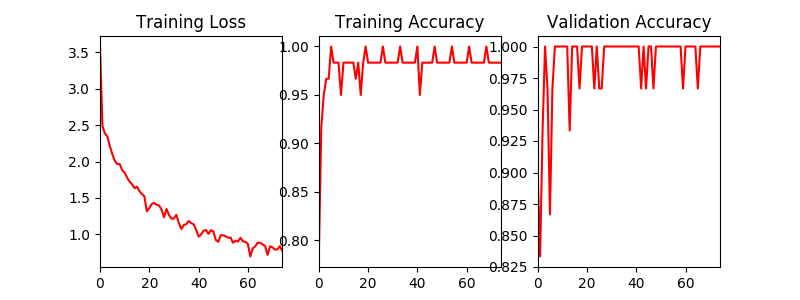

/home/murilo/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


In [13]:
"""Alterar estes hiperparametros"""
epochs = 75
batch_size = 10
""""""

"""Nao alterar abaixo"""
# Cria o grafico e atualiza os pesos
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,3))
ax1.set_title('Training Loss')
ax2.set_title('Training Accuracy')
ax3.set_title('Validation Accuracy')

t = tqdm(range(epochs))

losses = []
training_accuracy = []
accuracy = []

drawn, = ax1.plot(np.arange(0), losses, c='r')
drawn2, = ax2.plot(np.arange(0), training_accuracy, c='r')
drawn3, = ax3.plot(np.arange(0), accuracy, c='r')

# Loop de treinamento
for e in t:
    df = df.sample(frac=1., random_state=SEED)
    total_loss = 0
    correct = 0
    total = 0
    # Loop da epoca
    for i in range(0, df.shape[0]-batch_size, batch_size):
        total += batch_size
        batch = df.iloc[i:(i+batch_size), :]
        y = df.iloc[i:(i+batch_size)]
        y = y.loc[:, "target"]
        batch = batch.drop(["target"], axis=1)
        predictions = logreg.forward(batch.values)
        loss, grads = logreg.backward(y)
        total_loss += loss
        logreg.optimize()
#         correct += sum(y.values == (predictions > 0.5)) #shouldn't it be gte?
        correct += sum(y.values == (predictions >= 0.5))
    
    # Atualiza estatisticas e graficos
    training_accuracy.append(correct/total)
    losses.append(total_loss)
    t.set_description('Loss: %.3f' % total_loss)
    drawn.set_data((np.arange(len(losses)), losses))
    ax1.relim()
    ax1.set_xlim((0, e))
    ax1.autoscale_view()
    
    drawn2.set_data((np.arange(len(training_accuracy)), training_accuracy))
    ax2.relim()
    ax2.set_xlim((0, e))
    ax2.autoscale_view()
    #fig.canvas.draw()
    
    
    ### VALIDACAO ###
    batch = df_val
    y = df_val.loc[:, "target"]
    batch = batch.drop(["target"], axis=1)

    predictions = logreg.forward(batch.values)
    correct = np.sum(y.values == (predictions > 0.5))
    accuracy.append(correct/df_val.shape[0])
    
    # Atualiza graficos
    drawn3.set_data((np.arange(len(accuracy)), accuracy))
    ax3.relim()
    ax3.set_xlim((0, e))
    ax3.autoscale_view()
    fig.canvas.draw()

# É possível analisar a fronteira de decisão do classificador gerado. Este tipo de análise contribui para interpretação do classificador.

<IPython.core.display.Javascript object>


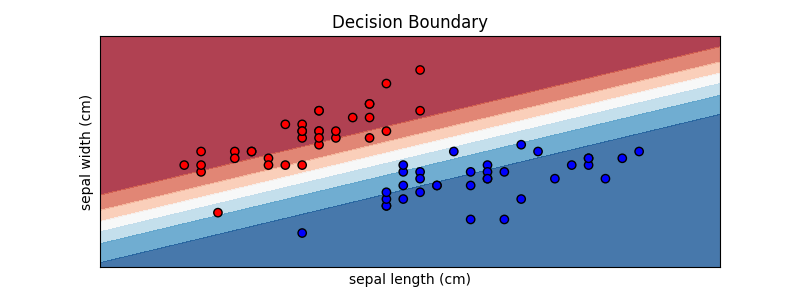

Text(0,0.5,'sepal width (cm)')

In [14]:
"""Nao alterar"""
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

h = .02

values = df.values
y = df.loc[:, "target"]
X1 = values[:, 0]
X2 = values[:, 1]

# Gera pontos interpolados para geracao da fronteira de decisao
x1_min, x1_max = X1.min() - .5, X1.max() + .5
x2_min, x2_max = X2.min() - .5, X2.max() + .5
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                       np.arange(x2_min, x2_max, h))


# Prediz a probabilidade dos pontos
points = np.c_[xx1.ravel(), xx2.ravel()]
predictions = logreg.forward(points)
predictions = predictions.reshape(xx1.shape)

# Gera o grafico
fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(1, 1, 1)

ax.set_xlim(xx1.min(), xx1.max())
ax.set_ylim(xx2.min(), xx2.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decision Boundary')

cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cm = plt.cm.RdBu

ax.contourf(xx1, xx2, predictions, cmap=cm, alpha=.8)

ax.scatter(X1, X2, c=y, cmap=cm_bright, edgecolors='k')

ax.set_xlim(xx1.min(), xx1.max())
ax.set_ylim(xx2.min(), xx2.max())
ax.set_xticks(())
ax.set_yticks(())

ax.set_xlabel(df.columns[0])
ax.set_ylabel(df.columns[1])